# Twitter Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Juan Manuel Rodriguez, Salomey Osei, Gonzalo Uribarri

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Step 1: Questions and goals

* Can we infer emotion from a tweet text?
* How words are distributed accross the dataset?
* Are words related to one kind of emotion?

---
# Step 2: Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

---
# Step 3: Load and explore the dataset

##  Install dependencies


In [ ]:
# @title Install dependencies
# !pip install pandas --quiet
# !pip install torchtext --quiet

In [1]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import cudf

import requests, zipfile, io

import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import string

from ast import literal_eval
import gc

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You can find the dataset we are going to use in [this website](http://help.sentiment140.com/for-students/).

**SECTION A**

In [ ]:
# USE THIS WHEN TWITTER DATA SET IS NOT AVAILABLE, IF ALREADY AVAILABLE LOAD FROM THE DIRECTORY
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Let's have a look at it
df.head()

**SECTION A.1**

In [ ]:
# IF THE DATA LOADED IS UNPROCESSED USE THE FOLLOWING CODE TO PROCESS DATA, 
# IF PROCESSED DATA IS AVAILABLE SKIP THIS SECTION AND CONTINUE AT SECTION B
######################################################################################
#Lets make a copy of the data set before playing around with it
df1 = df.copy()

######################################################################################
#remove URLs
pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
def rem_url(x):
  match = re.findall(pattern, x)
  for m in match:
    url = m[0]
    x = x.replace(url, '')
  return x
df1['url_removed'] = df1['text'].apply(lambda x:rem_url(x))
# df1.head()
print('URL removed')

######################################################################################
#remove twitter handles from text
tknzr = TweetTokenizer(strip_handles=True)
df1['handle_removed'] = df1['url_removed'].apply(lambda x:tknzr.tokenize(x))
# df1.head()
print('Twitter Handles removed')
# detokenize the tweet again
from nltk.tokenize.treebank import TreebankWordDetokenizer
df1['orig'] = df1['handle_removed'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))
print('Tweets detokenized again')

######################################################################################
# remove punctuations
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df1['clean_msg']= df1['orig'].apply(lambda x:remove_punctuation(x))
# df1.head()
print('Punctuation removed')

######################################################################################
# delete the unnecessary columns
del df1['url_removed']
del df1['handle_removed']
del df1['orig']

######################################################################################
# remove the upper case letters
df1['msg_lower'] = df1['clean_msg'].apply(lambda x: x.lower())
print('All set to lower case')

######################################################################################
# tokenize
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
#applying function to the column
tknzr = TweetTokenizer(strip_handles=True)
df1['msg_tokenied'] = df1['msg_lower'].apply(lambda x:tknzr.tokenize(x))
print('Tweet tokenized again')

######################################################################################
# removing stop words
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
#applying the function
df1['no_stopwords']= df1['msg_tokenied'].apply(lambda x:remove_stopwords(x))
print('Stopwords removed')

######################################################################################
#importing the Stemming function from nltk library
#defining the object for stemming
porter_stemmer = PorterStemmer()
#defining a function for stemming
def stemming(text):
  stem_text = [porter_stemmer.stem(word) for word in text]
  return stem_text
df1['msg_stemmed']=df1['no_stopwords'].apply(lambda x: stemming(x))
print('Tweets stemmed')

######################################################################################
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
# nltk.download('wordnet')
#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text
df1['msg_lemmatized']=df1['no_stopwords'].apply(lambda x:lemmatizer(x))
print('Tweets Lemmatized')

######################################################################################
# Let's create a 3rd copy of the processed dataset and continue to work with it and modifying it for legibility
df2 = df1.copy()
df2.head()

**SECTION A.2**

In [ ]:
# delete unneccessary columns
del df2['msg_lower']
del df2['text']
del df2['clean_msg']
del df
df2.head()

**SECTION A.3**

In [2]:
# Save the dataframe as a CSV file if not doens already
df2.to_csv('preprocessed_training_data_v2.csv')

NameError: name 'df2' is not defined

**Section B**

In [ ]:
# START FROM HERE IF ALREADY PROCESSED DATASET IS AVAILABLE FOR RUNNING RNN MODELS
# Note the upload from drive results in the columns being read as a whole string,
# intead use literal_eval to convert them to list.
# But since this steps requires an insane amount of RAM, do it only for the column you intend to use for RNN.
# Choose from the following ["msg_tokenied", "no_stopwords": literal_eval, "msg_stemmed": literal_eval,"msg_lemmatized"]
columns = ["msg_tokenied",  # 0
           "no_stopwords",  # 1
           "msg_stemmed",   # 2
           "msg_lemmatized" # 3
          ]
column_of_interest = columns[0]
df2 = pd.read_csv("../input/twittertrainingpreprocessed/preprocessed_training_data_v2.csv", index_col = 0,
                  converters={column_of_interest: literal_eval}
                 )

gc.collect()
df2.head()

**SECTION B.1**

Prepare the data for putting it in the model

In [ ]:
# Choose the column that you want to feed into the RNN model later on here
X = df2.msg_tokenied.values
# Changes values from [0,4] to [0,1]
y = (df2.polarity.values > 1).astype(int)

# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# # print out the sample data set
# for s, l in zip(x_train_text[:5], y_train[:5]):
#   print('{}: {}'.format(l, s))

x_train_token = x_train_text
x_test_token = x_test_text

# create a word counter
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1
    
#sort the words
sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:10])

count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

**SECTION B.2**

## Recurrent Neural Network with Pytorch

In [ ]:
# Set the device to use GPU
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

# Set the device (check if gpu is available)
device = set_device()

First we will create a Dictionary (`word_to_idx`). This dictionary will map each Token (usually words) to an index (an integer number). We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [ ]:
# Let us load the Glove embedded vectors by downloading it from the source (Stanford's website)
# However the dataset isalso available freely on Kaggle so consider using that directly and skip this section
# !wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
# !unzip glove.6B.zip
# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
# !unzip glove.twitter.27B.zip

In [ ]:
# If you wish to use the general Wiki based word vectors embedding use the glove.6B.___d.txt, the ___ is
# for how many dimensions do you want to ebed our word into.
# glove = pd.read_csv('glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
# glove_embedding = {key: val.values for key, val in glove.T.items()}

# If you wish to use the Tweets based word vectors embedding use the glove.twitter.27B.100d.txt
glove = pd.read_csv('../input/glovetwitter27b100dtxt/glove.twitter.27B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
glove_dim = 100

# # If you wish to use the Tweets based word vectors embedding use the glove.twitter.27B.200d.txt
# glove = pd.read_csv('../input/d/fullmetal26/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt', sep=" ", quoting=3, header=None, index_col=0)
# glove_embedding = {key: val.values for key, val in glove.T.items()}
# glove_dim = 200

In [ ]:
# Identify the most common words to use for anaylsis
#Let's select only the most used.
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

# We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and 
# one for padding the sequences (`'PAD'`).

# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}

# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word
    
# The following function helps create a word embedding matrix    
def create_embedding_matrix(word_index,embedding_dict,dimension):
  embedding_matrix=np.zeros((len(word_index)+1,dimension))
 
  for word,index in word_index.items():
    if word in embedding_dict:
      embedding_matrix[index]=embedding_dict[word]
  return embedding_matrix

# Let us use the function to create a word-embedding matrix 
# My word_to_idx is the same as their word_index
embedding_matrix=create_embedding_matrix(word_to_idx,embedding_dict=glove_embedding,dimension=glove_dim)


# Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. 
# These sequences of indexes will be the input to our pytorch model.

# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)



# We need all the sequences to have the same length. 
# To select an adequate sequence length, let's explore some statistics about the length of the tweets:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

In [ ]:
# We cut the sequences which are larger than our chosen maximum length (`max_length`) and fill with zeros the ones that are shorter.
# We choose the max length
max_length = 40 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Change this in case you want to use inputs of different lengths.

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
 features = np.zeros((len(sentences), seq_len),dtype=int)
 for ii, tweet in enumerate(sentences):
   len_tweet = len(tweet) 
   if len_tweet != 0:
     if len_tweet <= seq_len:
       # If its shorter, we fill with zeros (the padding Token index)
       features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
     if len_tweet > seq_len:
       # If its larger, we take the last 'seq_len' indexes
       features[ii, :] = np.array(tweet)[-seq_len:]
 return features


# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)


# Now, let's convert the data to pytorch format.

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)


# # Each batch of data in our traning proccess will have the folllowing format:
# # Obtain one batch of training data
# dataiter = iter(train_loader)
# sample_x, sample_y = dataiter.next()

# print('Sample input size: ', sample_x.size()) # batch_size, seq_length
# print('Sample input: \n', sample_x)
# print('Sample input: \n', sample_y)

**GENERAL MODEL**

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,hidden_dim, output_dim, vocab_size, embedding_dim, embedding_matrix,
                 model_name = 'LSTM', bi_directionality = False, use_pre_trained = True, 
                 tune_pre_trained = False, drop_prob=0.1):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.drop_prob = drop_prob
        self.model_name = model_name
        self.directions = bi_directionality
        self.use_pre_trained = use_pre_trained
        self.tune_pre_trained = tune_pre_trained
        if use_pre_trained:
            self.vocab_size = embedding_matrix.shape[0]
            self.embedding_dim = embedding_matrix.shape[1]
            # Embedding Layer
            self.embedding = nn.Embedding(self.vocab_size,self.embedding_dim)
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
            self.embedding.weight.requires_grad = self.tune_pre_trained
        else:
            self.vocab_size = vocab_size
            self.embedding_dim = embedding_dim
            # Embedding Layer
            self.embedding = nn.Embedding(self.vocab_size,self.embedding_dim)
    
    # Next layers based ont he model chosen
        if self.model_name == 'LSTM':
      # LSTM Layers
            self.lstm = nn.LSTM(input_size = self.embedding_dim,
                              hidden_size = self.hidden_dim,
                              num_layers = no_layers,
                              bidirectional = self.directions,
                              batch_first = True, 
                              dropout = self.drop_prob)
        else:
            self.gru = nn.GRU(input_size = self.embedding_dim,
                            hidden_size = self.hidden_dim,
                            num_layers = no_layers,
                            bidirectional = self.directions,
                            batch_first = True, 
                            dropout = self.drop_prob)
      
    
    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        if self.directions:
            self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
        else:
            self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
    
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
        if self.model_name == 'LSTM':
            batch_size = x.size(0)
            embeds = self.embedding(x)
            #Shape: [batch_size x max_length x embedding_dim]
            # LSTM out
            lstm_out, hidden = self.lstm(embeds, hidden)
            # Shape: [batch_size x max_length x hidden_dim]
            # Select the activation of the last Hidden Layer
            lstm_out = lstm_out[:,-1,:].contiguous()
            # Shape: [batch_size x hidden_dim]
            ## You can instead average the activations across all the times
            # lstm_out = torch.mean(lstm_out, 1).contiguous()
            # Dropout and Fully connected layer
            out = self.dropout(lstm_out)
            out = self.fc(out)
            # Sigmoid function
            sig_out = self.sig(out)
            # return last sigmoid output and hidden state
            return sig_out, hidden
        else:
            batch_size = x.size(0)
            self.h = self.init_hidden(batch_size)
            # Embedding out
            embeds = self.embedding(x)
            #Shape: [batch_size x max_length x embedding_dim]
            # GRU out
            gru_out, self.h = self.gru(embeds, self.h)
            # Shape: [batch_size x max_length x hidden_dim]
            # Select the activation of the last Hidden Layer
            gru_out = gru_out[:,-1,:].contiguous()
            # Shape: [batch_size x hidden_dim]
            # Dropout and Fully connected layer
            out = self.dropout(gru_out)
            out = self.fc(out)
            # Sigmoid function
            sig_out = self.sig(out)
            # return last sigmoid output and hidden state
            return sig_out

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        if self.directions:
            directionality = 2
        else:
            directionality = 1
    
        if self.model_name == 'LSTM':
            # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
            # initialized to zero, for hidden state and cell state of LSTM
            h0 = torch.zeros((self.no_layers * directionality, batch_size, self.hidden_dim)).to(device)
            c0 = torch.zeros((self.no_layers * directionality, batch_size, self.hidden_dim)).to(device)

            hidden = (h0,c0)
            return hidden
        else:
            hidden = (torch.zeros((self.no_layers * directionality, batch_size, self.hidden_dim)).to(device))
            return hidden

**MODEL TRAINING**

In [ ]:
def run_model(no_layers,hidden_dim, output_dim, vocab_size, embedding_dim, embedding_matrix,
              model_name, bi_directionality, use_pre_trained, tune_pre_trained,
              drop_prob, epochs, clip, lr, criterion, train_loader, valid_loader): 

    #######################################################################################
    # Parameters of our network
    # Let's define our model
    model = SentimentRNN(no_layers,hidden_dim, output_dim, vocab_size, embedding_dim, embedding_matrix,
                 model_name = model_name, bi_directionality = bi_directionality, use_pre_trained = use_pre_trained, 
                 tune_pre_trained = tune_pre_trained, drop_prob=drop_prob)
    # Moving to gpu
    model.to(device)
    print(model)

    #######################################################################################
    # How many trainable parameters does our model have?
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total Number of parameters: ',params)


    #######################################################################################
    # loss and optimization functions
    lr = lr
    # Binary crossentropy is a good loss function for a binary classification problem
    criterion = criterion
    # We choose an Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #>>>>> The optimizer function
    
    #######################################################################################
    # Number of training Epochs
    epochs = epochs
    # Maximum absolute value accepted for the gradeint
    clip = clip
    # Initial Loss value (assumed big)
    valid_loss_min = np.Inf

    # Lists to follow the evolution of the loss and accuracy
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    # Train for a number of Epochs
    for epoch in range(epochs):
      train_losses = []
      train_acc = 0.0
      model.train()

      for inputs, labels in train_loader:
        
        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)   
        
        if model.model_name == 'LSTM':
            # Initialize hidden state 
            h = model.init_hidden(batch_size)
            # Creating new variables for the hidden state
            h = tuple([each.data.to(device) for each in h])
            # Set gradient to zero
            model.zero_grad()
            # Compute model output
            output,h = model(inputs,h)
        else:
            # Initialize the hidden layer for first forward
            h = model.init_hidden(batch_size)
            # Set gradient to zero
            model.zero_grad()
            # Compute model output
            output = model(inputs,h)
        
        
        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


      # Evaluate on the validation set for this epoch 
      val_losses = []
      val_acc = 0.0
      model.eval()
      for inputs, labels in valid_loader:

        # Move batch inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)

        if model.model_name == 'LSTM':
            # Initialize hidden state 
            val_h = model.init_hidden(batch_size)
            # Creating new variables for the hidden state
            val_h = tuple([each.data.to(device) for each in val_h])
            # Set gradient to zero
            model.zero_grad()
            # Compute model output
            output, val_h = model(inputs,val_h)
        else:
            # Initialize the hidden layer for first forward
            val_h = model.init_hidden(batch_size)
            # Set gradient to zero
            model.zero_grad()
            # Compute model output
            output = model(inputs,val_h)

        # Compute Loss
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

      epoch_train_loss = np.mean(train_losses)
      epoch_val_loss = np.mean(val_losses)
      epoch_train_acc = train_acc/len(train_loader.dataset)
      epoch_val_acc = val_acc/len(valid_loader.dataset)
      epoch_tr_loss.append(epoch_train_loss)
      epoch_vl_loss.append(epoch_val_loss)
      epoch_tr_acc.append(epoch_train_acc)
      epoch_vl_acc.append(epoch_val_acc)
      print(f'Epoch {epoch+1}') 
      print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
      print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
      if epoch_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        valid_loss_min = epoch_val_loss
      print(25*'==')
    
    return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss

In [ ]:
# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [ ]:
model_name = 'LSTM'                 #>>>>> What kind of model? [Only LSTM or GRU possible]

no_layers = 4                       #>>>>> How many layers in the RNN?

hidden_dim = 32                     #>>>>> What dimension of the hidden layer?

vocab_size = 30000                  #>>>>> Vacabulary size?

embedding_dim = 32                  #>>>>> Embedding dimension?

embedding_matrix = embedding_matrix #>>>>> What embedding matrix to use? 
# [Set to None if you do not wish to use pre-trained network]

bi_directionality = True            #>>>>> Do you want to use bidirectional RNN? 
# [Default is False]

use_pre_trained = True             #>>>>> Should the model use the pre-trained embedding weights?

tune_pre_trained = True             #>>>>> Should the model tune the pre-trained embedding weights?
# [Default is False]

drop_prob=0.1                       #>>>>> What dropout probability to use, default is 0.1

epochs = 1                          #>>>>> No. of epochs

clip = 5                            #>>>>> Clippping the gradients

lr = 0.001                          #>>>>> Learning rate

criterion = nn.BCELoss()            #>>>>> Criterion for calculating the loss

out_dim = 1

epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = run_model(no_layers,hidden_dim, out_dim, vocab_size, embedding_dim, embedding_matrix,
                                                                      model_name, bi_directionality, use_pre_trained, tune_pre_trained,
                                                                      drop_prob, epochs, clip, lr, criterion, train_loader, valid_loader)

In [ ]:
# Looping through the whole array of variables
for model_name in ['GRU']:
    for no_layers in [4]:
        for hidden_dim in [32,64,128]:
            for bi_directionality in [True]:#, False]:
                for tune_pre_trained in [True]:#, False]:
                    for drop_prob in [0.1, 0.3]:
                        embedding_matrix = embedding_matrix
                        use_pre_trained = True
                        epochs = 1
                        vocab_size = 30000
                        embedding_dim = 32
                        for lr in [0.001, 0.005]:
                            criterion = nn.BCELoss()
                            out_dim = 1
                            clip = 5
                            print("##################################################################################################################################################\n")
                            print(f"The Model is {model_name} with {no_layers} layers, each of dimension {hidden_dim} with bi-directionality set to {bi_directionality} and pre-tuning set to {tune_pre_trained}.")
                            print(f"The dropout probability is {drop_prob} and learning rate is {lr}.")
                            epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss = run_model(no_layers,hidden_dim, out_dim, vocab_size, embedding_dim, embedding_matrix,
                                                                      model_name, bi_directionality, use_pre_trained, tune_pre_trained,
                                                                      drop_prob, epochs, clip, lr, criterion, train_loader, valid_loader)
                            del epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss
                            print("##################################################################################################################################################\n")

**Let us plot some results**

In [9]:
import seaborn as sns

df2 = pd.read_csv("../input/val-acc/data_val_acc.csv")
df2.columns

Index(['type_of_Model', 'no_of_hidden_layers', 'hidden_layer_dim',
       'no_of_parameters', 'dropout_rate', 'learning_rate', 'validation_acc'],
      dtype='object')

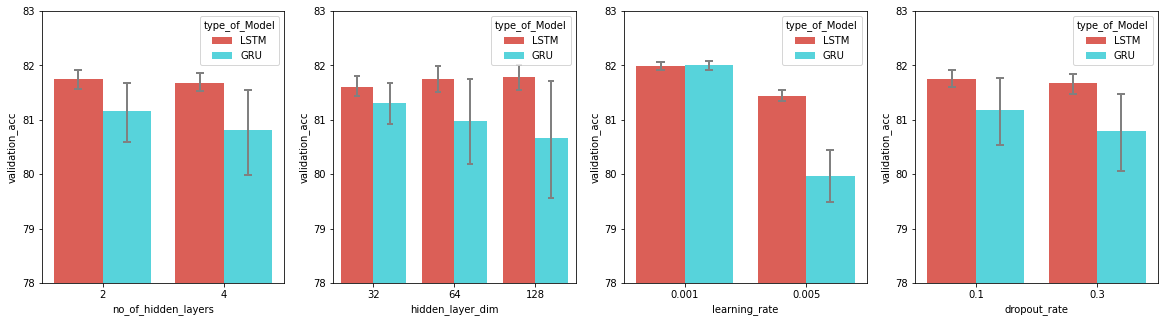

In [20]:

fig, axs = plt.subplots(1,4, figsize = (20,5))
sns.barplot(x = 'no_of_hidden_layers', y = 'validation_acc', data = df2, hue = 'type_of_Model',
            palette = 'hls',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 95, ax = axs[0]
            )
axs[0].set_ylim(78,83)
sns.barplot(x = 'hidden_layer_dim', y = 'validation_acc', data = df2, hue = 'type_of_Model',
            palette = 'hls',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 95, ax = axs[1]
            )
axs[1].set_ylim(78,83)
sns.barplot(x = 'learning_rate', y = 'validation_acc', data = df2, hue = 'type_of_Model',
            palette = 'hls',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 95, ax = axs[2]
            )
axs[2].set_ylim(78,83)
sns.barplot(x = 'dropout_rate', y = 'validation_acc', data = df2, hue = 'type_of_Model',
            palette = 'hls',
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 95, ax = axs[3]
            )
axs[3].set_ylim(78,83)
plt.show()

**LSTM UNI-DIRECTIONAL**

In [ ]:
# Let us a LSTM RNN using the pre-trianed embedding from GLOVE.
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, hidden_dim, embedding_matrix, drop_prob=0.1):
    super(SentimentLSTM,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.drop_prob = drop_prob
    self.vocab_size = embedding_matrix.shape[0]
    self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding Layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=True
    
    # LSTM Layers
    self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=False, batch_first=True, 
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    
    batch_size = x.size(0)
    
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]
    
    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]
    
    # Select the activation of the last Hidden Layer
#     lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

#######################################################################################
# Parameters of our network
# Size of our vocabulary
# Number of stacked LSTM layers
no_layers = 2
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.25
# Let's define our model
model = SentimentLSTM(no_layers, hidden_dim,embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

#######################################################################################
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

#######################################################################################
# Let us set up some parameters here.
# loss and optimization functions
lr = 0.005
# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()
# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#######################################################################################
# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

#######################################################################################
#lets run the model for one epoch to test its ability to run.
# Number of training Epochs
epochs = 3
# Maximum absolute value accepted for the gradeint
clip = 5
# Initial Loss value (assumed big)
valid_loss_min = np.Inf
# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
# plt.ylim([70, 80])
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

**GRU UNI-DIRECTIONAL**

In [ ]:
class SentimentGRU(nn.Module):
  def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob = 0.01):
    super(SentimentGRU,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.drop_prob = drop_prob
    self.vocab_size = embedding_matrix.shape[0]
    self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=True

    # GRU Layers
    self.gru = nn.GRU(input_size= self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=False, batch_first=True, 
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)
    self.h = self.init_hidden(batch_size)
    
    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # GRU out
    gru_out, self.h = self.gru(embeds, self.h)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    gru_out = gru_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    # Dropout and Fully connected layer
    out = self.dropout(gru_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out

  def init_hidden(self, batch_size):
    hidden = (torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device))
    return hidden

#######################################################################################
# Parameters of our network
# Number of stacked GRU layers
no_layers = 3
# Dimension of the hidden layer in LSTMs
hidden_dim = 128
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.25
# Let's define our model
model = SentimentGRU(no_layers, hidden_dim,
                     embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

#######################################################################################
# loss and optimization functions
lr = 0.001
# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()
# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

#######################################################################################
# Number of training Epochs
epochs = 3
# Maximum absolute value accepted for the gradeint
clip = 5
# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   
    
    # Initialize the hidden layer for first forward
    h = model.init_hidden(batch_size)
    
    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Initialize the hidden layer for first forward
    val_h = model.init_hidden(batch_size)
    
    # Compute model output
    output = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

#######################################################################################
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

**LSTM BI-DIRECTIONAL**

In [ ]:
class SentimentLSTM_bi(nn.Module):
  def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob=0.1):
    super(SentimentLSTM_bi,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.drop_prob = drop_prob
    self.vocab_size = embedding_matrix.shape[0]
    self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding Layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=True

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=True, batch_first=True, 
                        dropout=self.drop_prob)
    
    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]
    
    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]
    
    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers * 2,batch_size, self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers * 2,batch_size, self.hidden_dim)).to(device)
    
    hidden = (h0,c0)
    return hidden

#######################################################################################
# Parameters of our network
# Number of stacked LSTM layers
no_layers = 3
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.25
# Let's define our model
model = SentimentLSTM_bi(no_layers, hidden_dim,embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

#######################################################################################
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

# loss and optimization functions
lr = 0.005

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

#######################################################################################
#lets run the model for one epoch to test its ability to run.
# Number of training Epochs
epochs = 5
# Maximum absolute value accepted for the gradeint
clip = 5
# Initial Loss value (assumed big)
valid_loss_min = np.Inf
# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
# plt.ylim([70, 80])
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

**GRU BI-DIRECTIONAL**

In [ ]:
class SentimentGRU_bi(nn.Module):
  def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob = 0.01):
    super(SentimentGRU_bi,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.drop_prob = drop_prob
    self.vocab_size = embedding_matrix.shape[0]
    self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding layer
    self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
    self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
    self.embedding.weight.requires_grad=True

    # GRU Layers
    self.gru = nn.GRU(input_size= self.embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, bidirectional=True, batch_first=True, 
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)
    self.h = self.init_hidden(batch_size)
    
    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # GRU out
    gru_out, self.h = self.gru(embeds, self.h)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    gru_out = gru_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    # Dropout and Fully connected layer
    out = self.dropout(gru_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out

  def init_hidden(self, batch_size):
    hidden = (torch.zeros((self.no_layers * 2,batch_size,self.hidden_dim)).to(device))
    return hidden

#######################################################################################
# Parameters of our network
# Number of stacked GRU layers
no_layers = 3
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.25
# Let's define our model
model = SentimentGRU_bi(no_layers, hidden_dim,
                     embedding_matrix, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

#######################################################################################
# loss and optimization functions
lr = 0.001
# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()
# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

#######################################################################################
# Number of training Epochs
epochs = 1
# Maximum absolute value accepted for the gradeint
clip = 5
# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   
    
    # Initialize the hidden layer for first forward
    h = model.init_hidden(batch_size)
    
    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Initialize the hidden layer for first forward
    val_h = model.init_hidden(batch_size)
    
    # Compute model output
    output = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

#######################################################################################
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

**PLOTTING**

In [ ]:

#######################################################################################
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()